In [2]:
from subprocess import run
import glob
import os
import importlib
import mixing
import pandas as pd
importlib.reload(mixing)
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text
from collections import defaultdict
plt.rcParams["figure.figsize"] = (4,4)

In [3]:
paths = defaultdict(defaultdict)
for ANI, GEN in [('ANI90', '19000'), ('ANI95', '9000'), ('ANI97', '5000'), ('ANI99', '1000')]:
    paths[ANI]['FASTA'] = f'/manitou/pmg/projects/korem_lab/Projects/bacmeta_for_copan/bacmeta_SIDNPOP25NBAC2/CYbvDD/fastas/Generation_{GEN}'
    paths[ANI]['FASTQ'] =f'/burg/pmg/users/ic2465/Projects/MANU_copangraph/data/KmerMixing/bac_meta/{ANI}/fastq'
    paths[ANI]['MEGAHIT'] = f'/burg/pmg/users/ic2465/Projects/MANU_copangraph/data/KmerMixing/bac_meta/{ANI}/megahit'
    paths[ANI]['COPAN'] = f'/burg/pmg/users/ic2465/Projects/MANU_copangraph/data/KmerMixing/bac_meta/{ANI}/copan'
EXT_EXE = '/burg/pmg/users/ic2465/copangraph/bin/release/extension'
CPN_EXE = '/burg/pmg/users/ic2465/copangraph/bin/release/copangraph'
CPN_INI='''
# enter all config in 'key = value' format
app_name = cpg
log_file_dir = logs # path relative to the executable
log_level = 0 # possible values are 1ebug=0(includes Info and Error), Info=1(includes Error), Error=2, None=3
log_to = 0 # possible values are Console=0, File=1, ConsoleAndFile=2
sample_list = XSAMPLES 
graph_name = XNAME
out_dir = XOUTDIR 
divergence_threshold = XDT
num_threads = 8
max_separation = 400
window_size = 10
kmer_size = 15
min_homology_overlap = XMINHOMO
min_contiguity_overlap = 60
max_jump = XMAXJUMP # largest allowed gap within an alignment
high_freq_kmer_filter = 1e-5 # remove the top 1-x percentile kmers where x is input
fasta_file_ext = .fasta 
gfa_file_ext = .gfa
node_color_file_ext = .ncolor.csv
edge_color_file_ext = .ecolor.csv
extended_contigs = true 
sensitive_mode = true
asymmetric = false'''


In [6]:
for k, v in paths.items():
    for _, p in v.items():
        os.makedirs(p, exist_ok=True)

In [ ]:
# construct sequencing data
for k, v in paths.items():
    for fa in glob.glob(os.path.join(v['FASTA'], f'*.fasta')):
        base = os.path.splitext(os.path.basename(fa))[0]
        base = os.path.join(v['FASTQ'], base)
        cmd = f'art_illumina -ss HS25 -rs 42 -p -m 400 -s 10 -f 20 -i {fa} -l 150 -o {base}_'
        print(cmd)
        run(cmd, shell=True)
    run(f'pigz -f {v["FASTQ"]}/*.fq', shell=True)
    run(f'rm -f {v["FASTQ"]}/*.aln', shell=True)

In [18]:
# coassemble data

#pool
for k, v in paths.items():
    r1s = sorted(glob.glob(os.path.join(v['FASTQ'], '*_1.fq.gz')))
    r1s = ' '.join(r1s)
    cmd = f'zcat {r1s} > {v["FASTQ"]}/pooled_1.fq'
    print(cmd)
    run(cmd, shell=True)
    r2s = sorted(glob.glob(os.path.join(v['FASTQ'], '*_2.fq.gz')))
    r2s = ' '.join(r2s)
    cmd = f'zcat {r2s} > {v["FASTQ"]}/pooled_2.fq'
    print(cmd)
    run(cmd, shell=True)

    #compress
    run(f'pigz {v["FASTQ"]}/*.fq', shell=True)
    r1 = f'{v["FASTQ"]}/pooled_1.fq.gz'
    r2 = f'{v["FASTQ"]}/pooled_2.fq.gz'
    cmd = f'megahit -t 8 -1 {r1} -2 {r2} -o {v["MEGAHIT"]}/coasm'
    print(cmd)
    #run(cmd, shell=True)




zcat /burg/pmg/users/ic2465/Projects/MANU_copangraph/data/KmerMixing/bac_meta/ANI90/fastq/pop_0:rep_0_1.fq.gz /burg/pmg/users/ic2465/Projects/MANU_copangraph/data/KmerMixing/bac_meta/ANI90/fastq/pop_10:rep_0_1.fq.gz /burg/pmg/users/ic2465/Projects/MANU_copangraph/data/KmerMixing/bac_meta/ANI90/fastq/pop_11:rep_0_1.fq.gz /burg/pmg/users/ic2465/Projects/MANU_copangraph/data/KmerMixing/bac_meta/ANI90/fastq/pop_12:rep_0_1.fq.gz /burg/pmg/users/ic2465/Projects/MANU_copangraph/data/KmerMixing/bac_meta/ANI90/fastq/pop_13:rep_0_1.fq.gz /burg/pmg/users/ic2465/Projects/MANU_copangraph/data/KmerMixing/bac_meta/ANI90/fastq/pop_14:rep_0_1.fq.gz /burg/pmg/users/ic2465/Projects/MANU_copangraph/data/KmerMixing/bac_meta/ANI90/fastq/pop_15:rep_0_1.fq.gz /burg/pmg/users/ic2465/Projects/MANU_copangraph/data/KmerMixing/bac_meta/ANI90/fastq/pop_16:rep_0_1.fq.gz /burg/pmg/users/ic2465/Projects/MANU_copangraph/data/KmerMixing/bac_meta/ANI90/fastq/pop_17:rep_0_1.fq.gz /burg/pmg/users/ic2465/Projects/MANU_copan

In [20]:
# run megahit toolkit to make fastg format graphs
for k, v in paths.items():
    for fa in [e for e in glob.glob(f'{v["MEGAHIT"]}/coasm/intermediate_contigs/*.contigs.fa') if 'final' not in e]:
        kval = fa.split('.')[0]
        kval = os.path.basename(kval)
        kval = kval[1:]
        fastg = fa.replace('.contigs.fa', '.fastg')
        cmd = f'megahit_toolkit contig2fastg {kval} {fa} > {fastg}'
        print(cmd)
        run(cmd, shell=True)

megahit_toolkit contig2fastg 29 /burg/pmg/users/ic2465/Projects/MANU_copangraph/data/KmerMixing/bac_meta/ANI90/megahit/coasm/intermediate_contigs/k29.contigs.fa > /burg/pmg/users/ic2465/Projects/MANU_copangraph/data/KmerMixing/bac_meta/ANI90/megahit/coasm/intermediate_contigs/k29.fastg
megahit_toolkit contig2fastg 59 /burg/pmg/users/ic2465/Projects/MANU_copangraph/data/KmerMixing/bac_meta/ANI90/megahit/coasm/intermediate_contigs/k59.contigs.fa > /burg/pmg/users/ic2465/Projects/MANU_copangraph/data/KmerMixing/bac_meta/ANI90/megahit/coasm/intermediate_contigs/k59.fastg
megahit_toolkit contig2fastg 141 /burg/pmg/users/ic2465/Projects/MANU_copangraph/data/KmerMixing/bac_meta/ANI90/megahit/coasm/intermediate_contigs/k141.contigs.fa > /burg/pmg/users/ic2465/Projects/MANU_copangraph/data/KmerMixing/bac_meta/ANI90/megahit/coasm/intermediate_contigs/k141.fastg
megahit_toolkit contig2fastg 21 /burg/pmg/users/ic2465/Projects/MANU_copangraph/data/KmerMixing/bac_meta/ANI90/megahit/coasm/intermediat

In [ ]:
# run single sample assembly
for k, v in paths.items():
    r1s = sorted(glob.glob(os.path.join(v["FASTQ"], '*_1.fq.gz')))
    r2s = sorted(glob.glob(os.path.join(v["FASTQ"], '*_2.fq.gz')))
    reads_dict = dict()
    for r1, r2 in zip(r1s, r2s):
        if 'pooled' in r1:
            continue
        base = os.path.basename(r1).split(':')[0]
        reads_dict[base] = (r1, r2)
        cmd = f'megahit -t 8 -1 {r1} -2 {r2} -o {v["MEGAHIT"]}/{base}'
        print(cmd)
        run(cmd, shell=True)

In [ ]:
# run paired end extension
for k, v in paths.items():
    for asm_dir in glob.glob(f'{v["MEGAHIT"]}/pop_*'):
        fa = os.path.join(asm_dir, 'final.contigs.fa')
        cmd = f'bowtie2-build --threads 8 {fa} {asm_dir}/idx'
        print(cmd)
        run(cmd, shell=True)
        base = os.path.basename(asm_dir).split(':')[0]
        r1 = v['FASTQ'] + '/' + base + ':rep_0_1.fq.gz'
        r2 = v['FASTQ'] + '/' + base + ':rep_0_2.fq.gz'
        cmd = f'bowtie2 --threads 6 -x {asm_dir}/idx -1 {r1} -2 {r2} | samtools view -bS - | samtools sort -n -o {asm_dir}/{base}.bam'
        print(cmd)
        run(cmd, shell=True)
        cmd = f'{EXT_EXE} -i {fa} -t 1 --pe-only -b {asm_dir}/{base}.bam -o {asm_dir} -n {base} '
        print(cmd)
        run(cmd, shell=True)


In [6]:
# Setup copangraph
for k, v in paths.items():
    pe_exts = list()
    for asm_dir in glob.glob(f'{v["MEGAHIT"]}/pop_*'):
        base = os.path.basename(asm_dir)
        pe_ext = os.path.join(asm_dir, f'{base}.pe_ext.fasta.gz')
        cmd = f'gunzip {pe_ext}'
        run(cmd, shell=True)
        pe_exts.append(pe_ext.replace('.gz', ''))

    os.makedirs(v['COPAN'], exist_ok=True)
    samples_file = os.path.join(v['COPAN'], 'samples.txt')
    with open(samples_file, 'w') as f:
        f.write('\n'.join(pe_exts))


In [11]:
# run copangraph
for k,v in paths.items():
    samples_file = os.path.join(v['COPAN'], 'samples.txt')
    for sd in [0.1, 0.05, 0.04, 0.03, 0.01, 0.005]:
        with open(os.path.join(v['COPAN'], f'copan_{sd*100}.ini'), 'w') as f:
            f.write(
                CPN_INI.replace('XDT', str(sd))\
                .replace('XNAME', f'copan_sd_{sd*100}')\
                .replace('XMAXJUMP', '750')\
                .replace('XMINHOMO', '1000')\
                .replace('XOUTDIR', v['COPAN'])\
                .replace('XSAMPLES', samples_file)
            )
        ini = os.path.join(v['COPAN'], f'copan_{sd*100}.ini')
        cmd = f'{CPN_EXE} {ini}'
        print(cmd)
        run(cmd, shell=True)


/burg/pmg/users/ic2465/copangraph/bin/release/copangraph /burg/pmg/users/ic2465/Projects/MANU_copangraph/data/KmerMixing/bac_meta/ANI90/copan/copan_10.0.ini
2024-12-10 18:09:47  23456242251712  [info]	Initializing... 
2024-12-10 18:09:47  23456242251712  [info]	
>>>> config.ini <<<< 
--------------------
extended_contigs=1
edge_color_file_ext=.ecolor.csv
sensitive_mode=1
node_color_file_ext=.ncolor.csv
gfa_file_ext=.gfa
min_contiguity_overlap=60
max_jump=750
app_name=cpg
fasta_file_ext=.fasta
log_file_dir=logs
log_level=0
graph_name=copan_sd_10.0
log_to=0
sample_list=/burg/pmg/users/ic2465/Projects/MANU_copangraph/data/KmerMixing/bac_meta/ANI90/copan/samples.txt
min_homology_overlap=1000
high_freq_kmer_filter=1e-5
max_separation=400
out_dir=/burg/pmg/users/ic2465/Projects/MANU_copangraph/data/KmerMixing/bac_meta/ANI90/copan
asymmetric=0
num_threads=8
divergence_threshold=0.1
window_size=10
kmer_size=15

2024-12-10 18:09:47  23456242251712  [info]	Retrieving a sample list from /burg/pmg

In [16]:
# run mixing analysis
# megahit mixing

df = pd.DataFrame(columns=['full_name', 'method', 'graph_variable', 'mixing_mean', 'mixing_median', 'mixing_var', 'mixing_sd', 'num_nodes', 'n50', 'num_k_samples', 'num_k_nodes', 'missing_prop', 'ani'])
for k, v in paths.items():
    k2s = mixing.kmer_to_sample(glob.glob(os.path.join(v['FASTA'], '*.fasta')), mode='freq')

    for fg in glob.glob(f'{v["MEGAHIT"]}/coasm/intermediate_contigs/*.fastg'):

        mix, missing_prop, num_k_samples, num_k_nodes = mixing.mixing(fg, k2s)
        num_nodes = mixing.num_nodes(fg)
        kval = os.path.basename(fg).split('.')[0][1:]
        df.loc[len(df), :] = [f'megahit_{kval}', 'MEGAHIT', int(kval), mix.mean(), mix.median(), mix.var(), mix.std(), num_nodes, pd.NA, num_k_samples, num_k_nodes, missing_prop, int(k[3:])]



Fasta(hdr=SIDNPOP25NBAC2;gen_19000;pop_12;rep_0, seq=ATTCTCATGA)
Fasta(hdr=SIDNPOP25NBAC2;gen_19000;pop_20;rep_0, seq=ATTCTCATGA)
Fasta(hdr=SIDNPOP25NBAC2;gen_19000;pop_6;rep_0, seq=AATCTCATGA)
Fasta(hdr=SIDNPOP25NBAC2;gen_19000;pop_24;rep_0, seq=ATTCTCATAA)
Fasta(hdr=SIDNPOP25NBAC2;gen_19000;pop_0;rep_0, seq=ATTCTCATGA)
Fasta(hdr=SIDNPOP25NBAC2;gen_19000;pop_23;rep_0, seq=ATTCTCATGT)
Fasta(hdr=SIDNPOP25NBAC2;gen_19000;pop_3;rep_0, seq=ATTCTCATGA)
Fasta(hdr=SIDNPOP25NBAC2;gen_19000;pop_17;rep_0, seq=ATTCTCATGA)
Fasta(hdr=SIDNPOP25NBAC2;gen_19000;pop_4;rep_0, seq=ATTCTCATGA)
Fasta(hdr=SIDNPOP25NBAC2;gen_19000;pop_16;rep_0, seq=ATCTCTCATG)
Fasta(hdr=SIDNPOP25NBAC2;gen_19000;pop_19;rep_0, seq=ATGCTCACGA)
Fasta(hdr=SIDNPOP25NBAC2;gen_19000;pop_11;rep_0, seq=ATTCTCATAA)
Fasta(hdr=SIDNPOP25NBAC2;gen_19000;pop_2;rep_0, seq=ATTCTCATGA)
Fasta(hdr=SIDNPOP25NBAC2;gen_19000;pop_22;rep_0, seq=ATTCTCATGA)
Fasta(hdr=SIDNPOP25NBAC2;gen_19000;pop_15;rep_0, seq=ATTCTCATGA)
Fasta(hdr=SIDNPOP25NBAC2;gen_1

In [3]:
kmer_sets = mixing.get_kmer_sets(glob.glob(paths['ANI95']['FASTA'] + '/*.fasta'))

25it [04:40, 11.22s/it]


In [21]:
# Run 'seq in genome' mixing
seq_in_genome = list()
for fg in glob.glob(f'{paths['ANI95']["MEGAHIT"]}/coasm/intermediate_contigs/*.fastg'):
    df_mix = mixing.seq_in_genome_mixing(
        fg, 
        glob.glob(paths['ANI95']['FASTA'] + '/*.fasta'), 
        os.path.splitext(os.path.basename(fg))[0],
        kmer_sets, 
        candidate_its=20
    )
    seq_in_genome.append(df_mix)
seq_in_genome = pd.concat(seq_in_genome)
seq_in_genome.to_csv('seq_in_genome_mh.csv')

Num genomes read:  25
parsing graph...


 45%|████▍     | 19183/42691 [01:50<02:15, 173.30it/s]


KeyboardInterrupt: 

In [61]:
# Run 'seq in genome' mixing
seq_in_genome = list()
for fg in glob.glob(f'{paths['ANI95']["COPAN"]}/*.gfa'):
    print(fg)
    df_mix = mixing.seq_in_genome_mixing(
        fg, 
        glob.glob(paths['ANI95']['FASTA'] + '/*.fasta'), 
        os.path.splitext(os.path.basename(fg))[0],
        kmer_sets, 
        candidate_its=20
    )
    seq_in_genome.append(df_mix)
seq_in_genome = pd.concat(seq_in_genome)
seq_in_genome.to_csv('seq_in_genome_mh.csv')

/burg/pmg/users/ic2465/Projects/MANU_copangraph/data/KmerMixing/bac_meta/ANI95/copan/copan_sd_10.0.gfa
Num genomes read:  25
parsing graph...


100%|██████████| 1/1 [00:05<00:00,  5.02s/it]


/burg/pmg/users/ic2465/Projects/MANU_copangraph/data/KmerMixing/bac_meta/ANI95/copan/copan_sd_0.5.gfa
Num genomes read:  25
parsing graph...


100%|██████████| 25/25 [00:05<00:00,  4.88it/s]


/burg/pmg/users/ic2465/Projects/MANU_copangraph/data/KmerMixing/bac_meta/ANI95/copan/copan_sd_3.0.gfa
Num genomes read:  25
parsing graph...


100%|██████████| 25/25 [00:05<00:00,  4.94it/s]


/burg/pmg/users/ic2465/Projects/MANU_copangraph/data/KmerMixing/bac_meta/ANI95/copan/copan_sd_5.0.gfa
Num genomes read:  25
parsing graph...


100%|██████████| 1/1 [00:05<00:00,  5.06s/it]


/burg/pmg/users/ic2465/Projects/MANU_copangraph/data/KmerMixing/bac_meta/ANI95/copan/copan_sd_1.0.gfa
Num genomes read:  25
parsing graph...


100%|██████████| 25/25 [00:05<00:00,  4.88it/s]


/burg/pmg/users/ic2465/Projects/MANU_copangraph/data/KmerMixing/bac_meta/ANI95/copan/copan_sd_4.0.gfa
Num genomes read:  25
parsing graph...


100%|██████████| 25/25 [00:05<00:00,  4.95it/s]


In [4]:
#PLOT
seq_in_genome = pd.read_csv('seq_in_genome_copan.csv', index_col=0)
seq_in_genome.tool = seq_in_genome.tool.apply(lambda x: os.path.splitext(os.path.basename(x))[0])
plot_dat = seq_in_genome.groupby('tool').apply(
    lambda x: pd.Series(
        [
            x.nid.shape[0],  # how many nodes?
            x.total_bp.sum(), # total bp in graph?
            x.max_bp.sum(),  # total bp in graph, if we only take the longest seq in each node?
            x.is_multi_genome.sum()/x.shape[0],  # proportion of multi genome nodes?
            x.is_single_genome.sum()/x.shape[0],  # proportion of single genome nodes?
            (x.unmapped_bp == x.total_bp).sum()/x.shape[0], # proportion of unmapped nodes
            x.num_genomes_in.sum()/x.shape[0],  # average number of genomes per node?
            x.has_unmapped.sum()/x.shape[0], # proportion of nodes containing some unmapped sequence?
            x.unmapped_bp.sum(), # sum total unmapped
            x.unmapped_bp.sum()/x.total_bp.sum()# propotion bp unmappable
        ],
        index=[
            'num_nodes', 'total_bp_in_graph', 'sum_max_seq_per_node', 
            'multi_genome_node_proportion', 'single_genome_node_proportion', 'unmapped_node_proportion',
            'mean_num_genomes_per_node', 'node_has_unmapped_sequences_proportion', 
            'total_unmapped_bp', 'proportion_bp_unmappable'
        ]
    )
)
plot_dat['parameter'] = plot_dat.index.to_series().apply(lambda x: int(x[1:]) if 'copan' not in x else float(x.split('_')[-1]))
plot_dat['tool'] = plot_dat.index.to_series().apply(lambda x: 'copan' if 'copan' in x else 'megahit')
plot_dat['proportion_bp_mappable'] = 1-plot_dat.proportion_bp_unmappable
plot_dat.index = range(len(plot_dat))
n50_dat_mh = pd.DataFrame([['megahit', int(os.path.splitext(os.path.basename(f))[0][1:]), mixing.n50(f)] for f in glob.glob(paths['ANI95']['MEGAHIT']+ '/coasm/intermediate_contigs/*.fastg')], columns=['tool', 'parameter', 'n50'])
n50_dat_cn = pd.DataFrame([['copan', float(os.path.splitext(os.path.basename(f))[0].split('_')[-1]), mixing.n50(f)] for f in glob.glob(paths['ANI95']['COPAN']+ '/*.gfa')], columns=['tool', 'parameter', 'n50'])
n50_dat = pd.concat([n50_dat_mh, n50_dat_cn])
plot_dat = pd.merge(n50_dat, plot_dat, on=['tool', 'parameter'], how='inner')

/burg/pmg/users/ic2465/tmp/ipykernel_3750436/2289563729.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  plot_dat = seq_in_genome.groupby('tool').apply(


In [4]:

plot_dat

,tool,parameter,n50,num_nodes,total_bp_in_graph,sum_max_seq_per_node,multi_genome_node_proportion,single_genome_node_proportion,unmapped_node_proportion,mean_num_genomes_per_node,node_has_unmapped_sequences_proportion,total_unmapped_bp,proportion_bp_unmappable,proportion_bp_mappable
0,megahit,59.0,297,42691.0,14519841.0,14519841.0,0.010892,0.768195,0.220913,0.809609,0.220913,6292766.0,0.433391,0.566609
1,megahit,79.0,274,143041.0,33589786.0,33589786.0,0.088583,0.508910,0.402507,0.832209,0.402507,16377011.0,0.487559,0.512441
2,megahit,99.0,310,195031.0,51646790.0,51646790.0,0.051392,0.479247,0.469361,0.632643,0.469361,27440587.0,0.531313,0.468687
3,megahit,21.0,56,714654.0,35001233.0,35001233.0,0.311471,0.671962,0.016567,2.435323,0.016567,1131448.0,0.032326,0.967674
4,megahit,119.0,387,202578.0,67688672.0,67688672.0,0.032333,0.456599,0.511067,0.541663,0.511067,38408805.0,0.567433,0.432567
5,megahit,29.0,446,39968.0,7352742.0,7352742.0,0.091423,0.707716,0.200861,1.268965,0.200861,4455054.0,0.605904,0.394096
6,megahit,141.0,580,181258.0,81621077.0,81621077.0,0.020120,0.422585,0.557294,0.470732,0.557294,50573364.0,0.619612,0.380388
7,megahit,39.0,1770,10953.0,5449784.0,5449784.0,0.054688,0.562951,0.382361,0.862960,0.382361,4433298.0,0.813481,0.186519
8,copan,10.0,3999774,1.0,99994536.0,4003083.0,1.000000,0.000000,0.000000,24.000000,1.000000,3999774.0,0.040000,0.960000
9,copan,0.5,3999803,25.0,99995462.0,99995462.0,0.000000,0.960000,0.040000,0.960000,0.040000,3999803.0,0.040000,0.960000


In [ ]:

# megahit num nodes
ax=sns.lineplot(x=plot_dat.loc[plot_dat.tool == 'megahit', :].parameter, y=plot_dat.loc[plot_dat.tool == 'megahit', :]['num_nodes'], color='red')
ax.set_yscale('log')
ax.set_ylim(0.5,1e6)
ax.set_xticks(plot_dat.loc[plot_dat.tool == 'megahit'].parameter.sort_values())
plt.savefig(f'mh_num_nodes_labelled.pdf', dpi=1400, bbox_inches='tight')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')
plt.tight_layout()
plt.savefig(f'mh_num_nodes_unlabelled.pdf', dpi=1400, bbox_inches='tight')
plt.clf()

# copan num nodes
ax=sns.lineplot(x=plot_dat.loc[plot_dat.tool == 'copan', :].parameter, y=plot_dat.loc[plot_dat.tool == 'copan', :]['num_nodes'], color='blue')
ax.set_xticks(plot_dat.loc[plot_dat.tool == 'copan'].parameter.sort_values())
ax.set_yscale('log')
ax.set_ylim(0.5,1e6)
plt.savefig(f'copan_num_nodes_labelled.pdf', dpi=1400, bbox_inches='tight')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')
plt.tight_layout()
plt.savefig(f'copan_num_nodes_unlabelled.pdf', dpi=1400, bbox_inches='tight')
plt.clf()


# megahit n50
ax=sns.lineplot(x=plot_dat.loc[plot_dat.tool == 'megahit', :].parameter, y=plot_dat.loc[plot_dat.tool == 'megahit', :]['n50'], color='red')
ax.set_yscale('log')
ax.set_ylim(10,1e7+10000)
ax.set_xticks(plot_dat.loc[plot_dat.tool == 'megahit'].parameter.sort_values())
plt.savefig(f'mh_n50_labelled.pdf', dpi=1400, bbox_inches='tight')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')
plt.tight_layout()
plt.savefig(f'mh_n50_unlabelled.pdf', dpi=1400, bbox_inches='tight')
plt.clf()

# copan n50
ax=sns.lineplot(x=plot_dat.loc[plot_dat.tool == 'copan', :].parameter, y=plot_dat.loc[plot_dat.tool == 'copan', :]['n50'], color='blue')
ax.set_yscale('log')
ax.set_ylim(10,1e7+10000)
ax.set_xticks(plot_dat.loc[plot_dat.tool == 'copan'].parameter.sort_values())
plt.savefig(f'copan_n50_labelled.pdf', dpi=1400, bbox_inches='tight')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')
plt.tight_layout()
plt.savefig(f'copan_n50_unlabelled.pdf', dpi=1400, bbox_inches='tight')
plt.clf()


# megahit total bp in graph
ax=sns.lineplot(x=plot_dat.loc[plot_dat.tool == 'megahit', :].parameter, y=plot_dat.loc[plot_dat.tool == 'megahit', :]['total_bp_in_graph'], color='red')
ax.set_yscale('log')
ax.set_ylim(1e6,2*1e8)
ax.set_xticks(plot_dat.loc[plot_dat.tool == 'megahit'].parameter.sort_values())
plt.savefig(f'mh_total_bp_in_graph_labelled.pdf', dpi=1400, bbox_inches='tight')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')
plt.tight_layout()
plt.savefig(f'mh_total_bp_in_graph_unlabelled.pdf', dpi=1400, bbox_inches='tight')
plt.clf()

# copan total bp in graph
ax=sns.lineplot(x=plot_dat.loc[plot_dat.tool == 'copan', :].parameter, y=plot_dat.loc[plot_dat.tool == 'copan', :]['total_bp_in_graph'], color='blue')
ax.set_yscale('log')
ax.set_ylim(1e6,2*1e8)
ax.set_xticks(plot_dat.loc[plot_dat.tool == 'copan'].parameter.sort_values())
plt.savefig(f'copan_total_bp_in_graph_labelled.pdf', dpi=1400, bbox_inches='tight')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')
plt.tight_layout()
plt.savefig(f'copan_total_bp_in_graph_unlabelled.pdf', dpi=1400, bbox_inches='tight')
plt.clf()


# megahit prop bp mappable
ax=sns.lineplot(x=plot_dat.loc[plot_dat.tool == 'megahit', :].parameter, y=plot_dat.loc[plot_dat.tool == 'megahit', :]['proportion_bp_mappable'], color='red')
ax.set_ylim(0, 1.05)
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_xticks(plot_dat.loc[plot_dat.tool == 'megahit'].parameter.sort_values())
plt.savefig(f'mh_proportion_bp_mappable_labelled.pdf', dpi=1400, bbox_inches='tight')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')
plt.tight_layout()
plt.savefig(f'mh_proportion_bp_mappable_unlabelled.pdf', dpi=1400, bbox_inches='tight')
plt.clf()

# copan prop bp mappable
ax=sns.lineplot(x=plot_dat.loc[plot_dat.tool == 'copan', :].parameter, y=plot_dat.loc[plot_dat.tool == 'copan', :]['proportion_bp_mappable'], color='blue')
ax.set_ylim(0, 1.05)
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_xticks(plot_dat.loc[plot_dat.tool == 'copan'].parameter.sort_values())
plt.savefig(f'copan_proportion_bp_mappable_labelled.pdf', dpi=1400, bbox_inches='tight')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')
plt.tight_layout()
plt.savefig(f'copan_proportion_bp_mappable_unlabelled.pdf', dpi=1400, bbox_inches='tight')
plt.clf()


# megahit mean genomes per node
ax=sns.lineplot(x=plot_dat.loc[plot_dat.tool == 'megahit', :].parameter, y=plot_dat.loc[plot_dat.tool == 'megahit', :]['mean_num_genomes_per_node'], color='red')
ax.set_ylim(0, 25.5)
ax.set_yticks(np.linspace(0, 25, 26))
ax.set_xticks(plot_dat.loc[plot_dat.tool == 'megahit'].parameter.sort_values())
plt.savefig(f'mh_mean_genome_per_node_labelled.pdf', dpi=1400, bbox_inches='tight')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')
plt.tight_layout()
plt.savefig(f'mh_mean_genome_per_node_unlabelled.pdf', dpi=1400, bbox_inches='tight')
plt.clf()

# copan mean genomes per node
ax=sns.lineplot(x=plot_dat.loc[plot_dat.tool == 'copan', :].parameter, y=plot_dat.loc[plot_dat.tool == 'copan', :]['mean_num_genomes_per_node'], color='blue')
ax.set_ylim(0, 25.5)
ax.set_yticks(np.linspace(0, 25, 26))
ax.set_xticks(plot_dat.loc[plot_dat.tool == 'copan'].parameter.sort_values())
plt.savefig(f'copan_mean_genome_per_node_labelled.pdf', dpi=1400, bbox_inches='tight')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')
plt.tight_layout()
plt.savefig(f'copan_mean_genome_per_node_unlabelled.pdf', dpi=1400, bbox_inches='tight')
plt.clf()


# megahit multi-single-unmapped
node_map_dat = plot_dat[['tool', 'parameter', 'multi_genome_node_proportion', 'single_genome_node_proportion', 'unmapped_node_proportion']].melt(id_vars=['tool', 'parameter'])
ax=sns.lineplot(x=node_map_dat.loc[node_map_dat.tool == 'megahit', :].parameter, y=node_map_dat.loc[node_map_dat.tool == 'megahit', :]['value'], color='red', style=node_map_dat.variable)
ax.set_ylim(0, 1.05)
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_xticks(plot_dat.loc[plot_dat.tool == 'megahit'].parameter.sort_values())
plt.savefig(f'mh_multi_single_unmapped_labelled.pdf', dpi=1400, bbox_inches='tight')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')
frame1 = plt.gca()
frame1.legend().set_visible(False)
plt.tight_layout()
plt.savefig(f'mh_multi_single_unmapped_unlabelled.pdf', dpi=1400, bbox_inches='tight')
plt.clf()

# copan multi-single-unmapped
ax=sns.lineplot(x=node_map_dat.loc[node_map_dat.tool == 'copan', :].parameter, y=node_map_dat.loc[node_map_dat.tool == 'copan', :]['value'], color='blue', style=node_map_dat.variable)
ax.set_ylim(0, 1.05)
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_xticks(plot_dat.loc[plot_dat.tool == 'copan'].parameter.sort_values())
plt.savefig(f'copan_multi_single_unmapped_labelled.pdf', dpi=1400, bbox_inches='tight')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')
frame1 = plt.gca()
frame1.legend().set_visible(False)
plt.tight_layout()
plt.savefig(f'copan_multi_single_unmapped_unlabelled.pdf', dpi=1400, bbox_inches='tight')
plt.clf()



/burg/pmg/users/ic2465/miniforge3/envs/manu-copangraph/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/burg/pmg/users/ic2465/miniforge3/envs/manu-copangraph/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/burg/pmg/users/ic2465/miniforge3/envs/manu-copangraph/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/burg/pmg/users/ic2465/miniforge3/envs/manu-copangraph/lib/python3.12/site-pack

<Figure size 400x400 with 0 Axes>

In [9]:
# run mixing analysis
# copan mixing
print('sample calc...')
for k, v in paths.items():
    k2s = mixing.kmer_to_sample(glob.glob(os.path.join(v['FASTA'], '*.fasta')), mode='freq')
    for gfa in glob.glob(f'{v["COPAN"]}/*.gfa'):
        mix, missing_prop, num_k_samples, num_k_nodes = mixing.mixing(gfa, k2s)
        num_nodes = mixing.num_nodes(gfa)
        seq_div = os.path.basename(gfa).replace('copan_sd_', '').replace('.gfa', '')
        df.loc[len(df), :] = [f'copan_{seq_div}', 'copan', float(seq_div), mix.mean(), mix.median(), mix.var(), mix.std(), num_nodes, pd.NA, num_k_samples, num_k_nodes, missing_prop, int(k[3:])]
df.to_csv('mixing_copan.csv')

sample calc...
Fasta(hdr=SIDNPOP25NBAC2;gen_19000;pop_12;rep_0, seq=ATTCTCATGA)
Fasta(hdr=SIDNPOP25NBAC2;gen_19000;pop_20;rep_0, seq=ATTCTCATGA)
Fasta(hdr=SIDNPOP25NBAC2;gen_19000;pop_6;rep_0, seq=AATCTCATGA)
Fasta(hdr=SIDNPOP25NBAC2;gen_19000;pop_24;rep_0, seq=ATTCTCATAA)
Fasta(hdr=SIDNPOP25NBAC2;gen_19000;pop_0;rep_0, seq=ATTCTCATGA)
Fasta(hdr=SIDNPOP25NBAC2;gen_19000;pop_23;rep_0, seq=ATTCTCATGT)
Fasta(hdr=SIDNPOP25NBAC2;gen_19000;pop_3;rep_0, seq=ATTCTCATGA)
Fasta(hdr=SIDNPOP25NBAC2;gen_19000;pop_17;rep_0, seq=ATTCTCATGA)
Fasta(hdr=SIDNPOP25NBAC2;gen_19000;pop_4;rep_0, seq=ATTCTCATGA)
Fasta(hdr=SIDNPOP25NBAC2;gen_19000;pop_16;rep_0, seq=ATCTCTCATG)
Fasta(hdr=SIDNPOP25NBAC2;gen_19000;pop_19;rep_0, seq=ATGCTCACGA)
Fasta(hdr=SIDNPOP25NBAC2;gen_19000;pop_11;rep_0, seq=ATTCTCATAA)
Fasta(hdr=SIDNPOP25NBAC2;gen_19000;pop_2;rep_0, seq=ATTCTCATGA)
Fasta(hdr=SIDNPOP25NBAC2;gen_19000;pop_22;rep_0, seq=ATTCTCATGA)
Fasta(hdr=SIDNPOP25NBAC2;gen_19000;pop_15;rep_0, seq=ATTCTCATGA)
Fasta(hdr=SIDNP

In [55]:
df = pd.read_csv('mixing_copan.csv', index_col=0)
df = df.loc[df.ani == 95, :]
df = df.loc[(df.method == 'MEGAHIT') | (df.full_name == 'copan_5.0')]
df.missing_prop = df.missing_prop.round(3)
df


,full_name,method,graph_variable,mixing_mean,mixing_median,mixing_var,mixing_sd,num_nodes,n50,num_k_samples,num_k_nodes,missing_prop,ani
8,megahit_59,MEGAHIT,59.0,0.946980,1.0,0.043666,0.208965,42691.0,NaN,39463324.0,39548226.0,0.778,95.0
9,megahit_79,MEGAHIT,79.0,0.681696,1.0,0.724146,0.850968,143041.0,NaN,39463324.0,39665591.0,0.680,95.0
10,megahit_99,MEGAHIT,99.0,0.470153,1.0,1.303976,1.141918,195031.0,NaN,39463324.0,39721624.0,0.601,95.0
11,megahit_21,MEGAHIT,21.0,0.986151,1.0,0.027016,0.164366,714654.0,NaN,39463324.0,39578160.0,0.491,95.0
12,megahit_119,MEGAHIT,119.0,0.409996,1.0,1.477398,1.215483,202578.0,NaN,39463324.0,39789798.0,0.512,95.0
13,megahit_29,MEGAHIT,29.0,0.995252,1.0,0.004308,0.065636,39968.0,NaN,39463324.0,39469923.0,0.840,95.0
14,megahit_141,MEGAHIT,141.0,0.419165,1.0,1.398270,1.182485,181258.0,NaN,39463324.0,39890605.0,0.417,95.0
15,megahit_39,MEGAHIT,39.0,0.995817,1.0,0.002045,0.045218,10953.0,NaN,39463324.0,39475351.0,0.874,95.0
39,copan_5.0,copan,5.0,1.000000,1.0,0.000000,0.000000,1.0,NaN,39463324.0,39463324.0,0.000,95.0


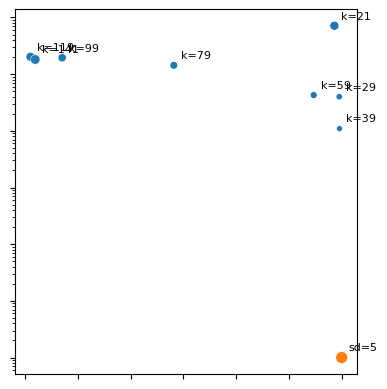

In [58]:

plt.figure(figsize=(4,4))
sns.scatterplot(x=df.mixing_mean, y=df.num_nodes, hue=df.method, size=1 - df.missing_prop)
plt.yscale('log')
texts = list()
for i in df.index:
    if df.loc[i, 'method'] == 'MEGAHIT':
        ano = f'k={int(df.graph_variable[i])}'
    else:
        ano = f'sd={int(df.graph_variable[i])}'
    plt.annotate(ano, (df.mixing_mean[i], df.num_nodes[i]), textcoords='offset points', xytext=(5, 5), size=8)
    #texts.append(plt.text(df.mixing_mean[i], df.num_nodes[i], ano, fontsize=8))
#adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))
plt.tight_layout()
plt.savefig('mixing_ANI95_labeled.pdf')
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])
frame1.legend().set_visible(False)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.savefig('mixing_ANI95_nolabeled.pdf')
plt.show()

9 [-0.32399182 -0.16776094]
11 [ 0.4617761  -0.09889175]


<Figure size 640x480 with 0 Axes>

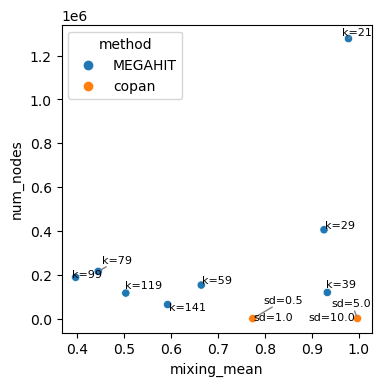

In [30]:
plt.clf()
plt.figure(figsize=(4,4))
sns.scatterplot(x=df.mixing_mean, y=df.num_nodes, hue=df.method)
texts = list()
for i in df.index:
    if df.loc[i, 'method'] == 'MEGAHIT':
        ano = f'k={df.graph_variable[i]}'
    else:
        ano = f'sd={df.graph_variable[i]}'
    #plt.annotate(ano, (df.mixing_mean[i], df.num_nodes[i]), textcoords='offset points', xytext=(5, 5))
    texts.append(plt.text(df.mixing_mean[i], df.num_nodes[i], ano, fontsize=8))
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))
plt.show()